In [30]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import MinMaxScaler
import torch
savepath = f"data"

In [2]:
def get_dtypes(data):
    data[data.dtypes[data.dtypes=='object'].index] = data[data.dtypes[data.dtypes=='object'].index].fillna(-1).astype('int')
    data[data.dtypes[data.dtypes=='bool'].index] = data[data.dtypes[data.dtypes=='bool'].index].fillna(-1).astype('int')

    return data


In [3]:
files = glob.glob(f'{savepath}/*')

labels = pd.read_csv(f'{savepath}/karma_data.csv',index_col=0)


address = pd.read_csv(f'{savepath}/address',index_col=0)
address = address.drop({'block_timestamp'},axis=1)#.join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(address['block_timestamp'])).dt.total_seconds()/60/24).round(0))
address = address.drop({'metadata_block_timestamp'},axis=1)#.join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(address['metadata_block_timestamp'])).dt.total_seconds()/60/24).round(0))

address = address.rename({'block_timestamp':'days_since_profile_created', 'metadata_block_timestamp':'days_since_metadata_changed'},axis=1)



dispatcher = pd.read_csv(f'{savepath}/dispatcher_data',index_col=0)
dispatcher = dispatcher.drop(['profile_dispatcher_address','dispatcher_setup_timestamp'],axis=1).join(pd.get_dummies(dispatcher['profile_dispatcher_address'])).join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(dispatcher['dispatcher_setup_timestamp'])).dt.total_seconds()/60/24).round(0))
dispatcher = dispatcher.rename({'dispatcher_setup_timestamp':'days_since_dispatcher_changed'},axis=1)

profile_data = pd.merge(dispatcher,address, on='profile_id', how='outer')


worldcoin_human = pd.read_csv(f'{savepath}/worldcoin_human_check',index_col=0)
worldcoin_human['worldcoin_human']=True
profile_data = pd.merge(profile_data,worldcoin_human, on='profile_id', how='outer')

aggregated_stats = pd.read_csv(f'{savepath}/aggregated_stats',index_col=0)
profile_data = pd.merge(profile_data,aggregated_stats, on='profile_id', how='outer')



def read_insight_data(profile_data, name, group_col='profile_id'):
    profile_data.copy()
    df = pd.read_csv(f'{savepath}/{name}',index_col=0)
    df.columns = [f'{i}_{name}' for i in df.columns]
    profile_data = pd.merge(profile_data,df, left_on=group_col,right_index=True, how='outer')
    return profile_data

profile_data = read_insight_data(profile_data, name='post_data_insights')

profile_data = read_insight_data(profile_data, name='comment_data_insights')

profile_data = read_insight_data(profile_data, name='mirror_data_insights')

profile_data = read_insight_data(profile_data, name='like_data_insights')


most_used_app = pd.read_csv(f'{savepath}/most_used_app',index_col=0)
most_used_app = most_used_app.join(pd.get_dummies(most_used_app[['app_id_highest_posts','app_id_highest_comments']])).drop(['app_id_highest_posts','app_id_highest_comments'],axis=1)
profile_data = pd.merge(profile_data,most_used_app, on='profile_id', how='outer')


ens_address = pd.read_csv(f'{savepath}/ens_address',index_col=0)
ens_address['ens']=True

proof_of_humanity = pd.read_csv(f'{savepath}/proof_of_humanity',index_col=0)
proof_of_humanity['proof_of_humanity']=True

sybil_dot_org_address_verified_twitter = pd.read_csv(f'{savepath}/sybil_dot_org_address_verified_twitter',index_col=0)
sybil_dot_org_address_verified_twitter['sybil_dot_org_address_verified_twitter']=True

address_data = pd.merge(ens_address,proof_of_humanity, on='address',how='outer')
address_data = pd.merge(address_data,sybil_dot_org_address_verified_twitter, on='address',how='outer')

address_data = read_insight_data(address_data, name='collect_data_insights',group_col='address')

address_data = read_insight_data(address_data, name='paid_collect_data_insights',group_col='address')

flipside = pd.read_csv(f'{savepath}/flipside_100k.csv').fillna(0)
address_data['ADDRESS'] = address_data['address'].str.lower()
address_data = address_data.merge(flipside,on='ADDRESS',how='right').drop('ADDRESS',axis=1)

data = profile_data.merge(address_data,on='address',how='inner').drop('address',axis=1)





def intify(x):
    return int(x,16)



data = data.dropna(subset=['profile_id'])
data['id'] = data['profile_id'].apply(intify)
data = data.set_index('profile_id')

data = data.merge(labels,on='id',how='inner')
data = data.fillna(-1)
data.head()

,0x112b57A293d99b79Fe360Af042bb3bfFc824Ab3a,0x25418Bcf53dAe1167cD5d0cad34Eec31C0C37E41,0x3530c7CAc2E47F27bA82a5d0D3671181171292DB,0x45F71328a415129CB25e3917e70f5BCA346C6151,0x46fAf146C4683663667af868dFc2F98ADc27fBd6,0x57B7bf6f792a6181Ec5aFB88cE7bcE330a9d1b67,0x62D0e168e35f87a1dB804C2b2daf63AE4D195cD1,0x6bC45934A408f7151093479bf59933cD3B75701d,0x761010EFc8826fFdcb8Ad005BD935698ed38DfE7,0x76D4fFdA8c66864FA07f0a285B8E01E11b4Bb7b3,...,USD_VALUE,MINTED_NFT,VOTED,ARBITRUM_COUNTS,OPTIMISM_COUNTS,id,score,rank,handle,followersCount
0,False,False,False,True,False,False,False,False,False,False,...,0.0,1.0,1.0,852.0,1073.0,44206,1.204615e-32,73917,lalalisa.lens,4
1,False,False,False,False,False,False,True,False,False,False,...,0.0,1.0,1.0,0.0,0.0,7059,5.603351e-32,55999,edaen.lens,11
2,False,False,False,False,False,False,True,False,False,False,...,0.0,0.0,1.0,0.0,0.0,54009,1.238152e-04,633,tincho.lens,183
3,False,False,False,False,False,False,True,False,False,False,...,0.0,1.0,0.0,0.0,0.0,61990,4.146219e-08,12129,levodd.lens,49
4,False,False,False,True,False,False,False,False,False,False,...,0.0,1.0,1.0,1.0,0.0,57006,3.785037e-36,96190,kamilmouthon.lens,3


In [102]:
a = [i for i in validation_data.columns if i.startswith('app_id_highest')]
drop_these = [i for i in a if i not in [
 'app_id_highest_posts_beats',
 'app_id_highest_posts_buttrfly',
 'app_id_highest_posts_chainjet',
 'app_id_highest_posts_memester',
 'app_id_highest_posts_lensport',
 'app_id_highest_posts_lensta',
 'app_id_highest_posts_lenster',
 'app_id_highest_posts_lenstube',
 'app_id_highest_posts_lenstube-bytes',
 'app_id_highest_posts_phaver',
 'app_id_highest_posts_orb',
    
 'app_id_highest_comments_beats',
 'app_id_highest_comments_buttrfly',
 'app_id_highest_comments_chainjet',
 'app_id_highest_comments_memester',
 'app_id_highest_comments_lensport',
 'app_id_highest_comments_lensta',
 'app_id_highest_comments_lenster',
 'app_id_highest_comments_lenstube',
 'app_id_highest_comments_lenstube-bytes',
 'app_id_highest_comments_phaver',
 'app_id_highest_comments_orb'
]]

In [112]:
for i in drop_these:
    if i in data.columns:
        data =  data.drop(i,axis=1)
bad = data.dropna(subset=['rank','total_mirrors']).query('total_mirrors>100').sort_values(by='rank').tail(500).drop(labels.columns,axis=1)
good = pd.concat([data.sort_values(by='rank').head(1500).drop(labels.columns,axis=1), data[data['worldcoin_human']==True].drop(labels.columns,axis=1)],axis=0).copy()
bad['label'] = 0
good['label'] = 1

training_data = pd.concat([bad,good],axis=0)
validation_data = data.drop(training_data.index).drop(labels.columns,axis=1)
training_data = get_dtypes(training_data)
validation_data = get_dtypes(validation_data)


In [113]:
X_train, X_test, y_train, y_test = train_test_split(training_data.drop('label',axis=1), training_data['label'], test_size=0.2, random_state=42)

In [114]:
mc = MinMaxScaler()
X_train.shape

(1635, 202)

In [115]:
data.shape

(78878, 207)

In [116]:

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs=1000
unsupervised_model.fit(
     eval_set=[mc.fit_transform(training_data.drop('label',axis=1).values)],
     X_train=mc.transform(validation_data.values),
    max_epochs=max_epochs , patience=10,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=True,
    pretraining_ratio=0.9,
) 

epoch 0  | loss: 102008993.31064| val_0_unsup_loss_numpy: 4.303850173950195|  0:00:08s
epoch 5  | loss: 28620.44505| val_0_unsup_loss_numpy: 1.5203100442886353|  0:00:50s


In [ ]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

In [ ]:
clf.fit(
    X_train=mc.fit_transform(X_train.values), y_train=y_train.values,
    eval_set=[(mc.transform(X_train.values), y_train.values), (mc.transform(X_test.values), y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=max_epochs , patience=5,
    batch_size=128, virtual_batch_size=36,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=unsupervised_model,
    
) 

In [ ]:
from sklearn.metrics import roc_auc_score


In [ ]:
preds = clf.predict_proba(mc.transform(validation_data.values))
# test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(mc.transform(X_test.values))
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
#print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

In [ ]:
pd.Series(preds.argmax(1)).value_counts()

In [ ]:
pd.Series(preds.argmax(1),name='label',index=validation_data.index).to_frame().join(data[labels.columns]).plot.scatter(x='rank',y='label',alpha=0.01,s=0.1)

In [125]:
pd.Series(preds.argmax(1),name='label',index=validation_data.index).to_frame().join(data[labels.columns]).query('followersCount>100')

,label,score,rank,handle,followersCount,id
10,1,2.215395e-10,32495,kacoma.lens,168,34655
12,1,7.014934e-08,10222,nbarokkets.lens,349,96010
13,1,1.755693e-07,7351,0x021.lens,451,64952
14,1,7.166682e-09,19856,cryptorg.lens,123,21087
15,1,1.157505e-08,17039,shitposting.lens,205,69471
...,...,...,...,...,...,...
78711,1,6.018760e-09,20578,biglittleant.lens,165,4693
78723,1,8.920118e-33,76003,zuiai.lens,202,52179
78743,1,1.534367e-10,33723,sassy.lens,368,12690
78745,1,1.068281e-06,4166,sassal.lens,887,13464


/var/folders/yt/6t964r9x3q51ryt05dfj1b3m0000gn/T/ipykernel_89547/3717420391.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['handle'], dtype='object')]

  results.to_hdf('data.hdf',key='df')


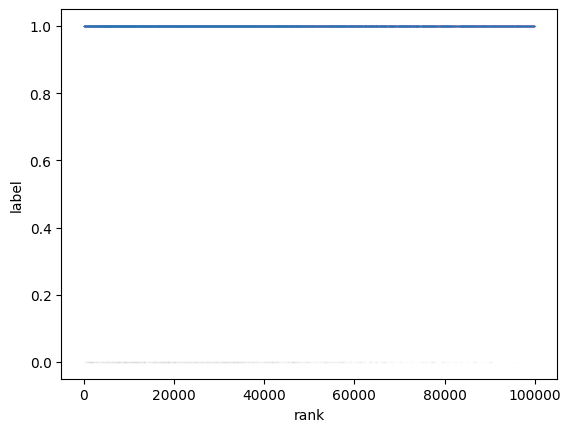

In [126]:
show_data = data.drop(labels.columns,axis=1)
preds = clf.predict_proba(mc.transform(show_data.values))
results = pd.Series(preds.argmax(1),
                    name='label',
                    index=show_data.index).to_frame().join(data[labels.columns])
results.plot.scatter(x='rank',y='label',alpha=0.01,s=0.1)

results.to_hdf('data.hdf',key='df')


In [127]:
results.head()

,label,score,rank,handle,followersCount,id
0,1,1.204615e-32,73917,lalalisa.lens,4,44206
1,1,5.603351e-32,55999,edaen.lens,11,7059
2,1,1.238152e-04,633,tincho.lens,183,54009
3,1,4.146219e-08,12129,levodd.lens,49,61990
4,1,3.785037e-36,96190,kamilmouthon.lens,3,57006
